# 프로젝트: 임베딩내 편향성 알아보기

# 프로젝트 루브릭  
  
1. 워드임베딩의 most_similar() 메소드 결과가 의미상 바르게 나왔다.  
    → OK  
2. 타당한 방법론을 통해 중복이 잘 제거되고 개념축을 의미적으로 잘 대표하는 단어 셋이 만들어졌다.  
    → OK  
3. 전체 영화 장르별로 예술/일반 영화에 대한 편향성 WEAT score가 상식에 부합하는 수치로 얻어졌으며 이를 잘 시각화하였다.  
    → OK  
    

# 실험 계획 및 히스토리  
1. 노드의 베이스구조를 계승  
2. attribute 대상 확대 6개 > 21개  
3. 대표 데이터셋 제작시 기존 Tf-Idf > + 유사도로 장르내 유사 단어제거 > + 고유 명사 불용어 처리   
    → 고유 명사 불용어 처리 후 WEAT 점수가 유의미하게 차이가 나기 시작함
      불용어는 수작업으로 제거하였으나, 코드를 통해 작업하는 방법에 대해서 알게됨.(사용해보지는 않음)   
5. 추가 작업: 장르별 유사도를 시각화하여 분석   
  

# 결과  
-대부분 기존 인식과 결이 같은 편향성을 보였다.  
-애니메이션과 가족, 액션과 범죄의 경우 예술과 상업에 편향성이 0에 수렴할 것으로 기대하였으나,  
 각각 -1, 1 수준의 점수로 편향성을 보였다.  
 데이터셋과 시놉시스 자체를 비교 분석하면 영향을 주는 특정 요소가 있을 것으로 추론되나 시간상 진행하지 못함  .
   

# 회고  
-편향성과 유사도라는 개념이 무척 흥미롭다.  
 수치로 의미를 판단한다는 것이 매력적이다.  
-편향성은 문제로 인식되고 있다.  
 물론 잘 관리해야할 대상이 맞다고 본다.  
 한편으로는 자연어 처리와 편향성을 잘 다루면 '사용자의 기대'를 추론할 수 있지 않을까 하는 생각이 들었다.  
 현업에서 제일 관심있는 것 중에 하나가 우리 서비스 사용자가 도데체 '우리에게 무엇을 기대하는 가?'이다. 
-이런 저런 생각해볼 만한 것과 해보고 싶은 것들이 있지만.....
 늘 그렇듯 당분간은 다음 프로젝트 제출에 전전긍긍하게되것지...  
  

In [ ]:
# 프로젝트 진행

# 데이터 편향성 문제의식
학습목표가 데이터의 편향성에 대한 문제의식을 설명하는 것이다.
    편향성의 사전적 의미는 한쪽으로 치우친 성질을 말한다. 
    데이터의 편향성이라 함은 데이터에는 의미가 담기 마련인데,
    그 의미가 한쪽으로 치우친다는 뜻일 것이다. 
이 것이 왜 문제가 될까?
    모델이 편향이 담긴 데이터를 학습하고, 출력에서 그 편향을 담는 다면 성능에 대한 문제가 발생할 수 있다.
    그 편향이 불평등, 차별, 왜곡을 담고 있다면 모델의 출력 또한 그럴 것이다.
    이런 문제적 편향에 따라 성능의 저하나, 신로도가 하락할 수 있고,
    나아가 사용자가 편향이 담긴 의사결정이나 인식을 가질 수 있다. 
    가장 비근한 예로 LLM 사용으로 의사결정을 참고하는 경우에 그런 문제가 발생할 수 있다.
    (한국이 소버린 Ai를 보유하고자 하는 목적도 같은 결에서 이해할 수 있다.)
즉 '데이터의 편향성에 대한 문제의식'이라는 것은 이런 문제에 대한 보편적인 우려를 말하는 것이라고 생각한다.


    

# 실험의 효율성을 위해 임베딩 모델을 저장해두고 불러 쓰는 방식으로 처리

In [2]:
#워드임베딩 모델 생성 및 저
# === 필요한 라이브러리 임포트 ===
import os
import pickle
from konlpy.tag import Okt
from gensim.models import Word2Vec

# === STEP 1: 데이터 준비 및 전처리 ===

# 1. 파일 경로 및 장르 목록 정의
data_dir = os.path.join(os.getenv("HOME"), "work/weat/data")
art_txt = os.path.join(data_dir, 'synopsis_art.txt')
gen_txt = os.path.join(data_dir, 'synopsis_gen.txt')

genre_files = [
    'synopsis_action.txt',
    'synopsis_adult.txt',
    'synopsis_adventure.txt',
    'synopsis_animation.txt',
    'synopsis_art.txt',
    'synopsis_comedy.txt',
    'synopsis_crime.txt',
    'synopsis_documentary.txt',
    'synopsis_drama.txt',
    'synopsis_etc.txt',
    'synopsis_family.txt',
    'synopsis_fantasy.txt',
    'synopsis_gen.txt',
    'synopsis_historical.txt',
    'synopsis_horror.txt',
    'synopsis_musical.txt',
    'synopsis_mystery.txt',
    'synopsis_romance.txt',
    'synopsis_SF.txt',
    'synopsis_show.txt',
    'synopsis_thriller.txt',
    'synopsis_war.txt',
    'synopsis_western.txt'
]
genre_paths = [os.path.join(data_dir, f) for f in genre_files]
all_paths = [art_txt, gen_txt] + genre_paths

# 2. 명사 추출 함수 (베이스라인과 동일)
def read_token(file_name):
    okt = Okt()
    result = []
    with open(file_name, 'r') as fread:
        print(f"{os.path.basename(file_name)} 파일 처리 중...")
        while True:
            line = fread.readline()
            if not line: break
            tokenlist = okt.pos(line, stem=True, norm=True)
            for word in tokenlist:
                if word[1] in ["Noun"]:
                    result.append(word[0])
    return (' '.join(result))

# 3. 모든 파일에 대해 명사 추출 실행
# art, gen 텍스트 및 각 장르 텍스트를 별도로 저장
art_corpus = read_token(art_txt)
gen_corpus = read_token(gen_txt)
genre_corpus_list = [read_token(p) for p in genre_paths]

# Word2Vec 학습을 위한 전체 통합 코퍼스 생성
# str을 split()하여 list of lists 형태로 변환
total_corpus_for_model = [c.split() for c in [art_corpus, gen_corpus] + genre_corpus_list]

# 4. 토큰화된 결과물 저장 (pickle)
# 반복적인 파일 읽기와 명사 추출 과정을 생략하기 위함
corpus_to_save = {
    'art': art_corpus,
    'gen': gen_corpus,
    'genres': genre_corpus_list,
    'genre_names': [os.path.basename(f).replace('synopsis_','').replace('.txt','') for f in genre_files]
}
with open('tokenized_corpus.pkl', 'wb') as f:
    pickle.dump(corpus_to_save, f)
print("✅ 토큰화된 코퍼스 저장 완료: tokenized_corpus.pkl")


# === STEP 2: 임베딩 모델 학습 및 저장 ===

# 1. Word2Vec 모델 학습
model = Word2Vec(total_corpus_for_model, vector_size=100, window=5, min_count=3, sg=0)
print("✅ Word2Vec 모델 학습 완료")

# 2. 학습된 모델 저장
# 반복적인 모델 학습 과정을 생략하기 위함
model.save("word2vec.model")
print("✅ 학습된 모델 저장 완료: word2vec.model")

synopsis_art.txt 파일 처리 중...
synopsis_gen.txt 파일 처리 중...
synopsis_action.txt 파일 처리 중...
synopsis_adult.txt 파일 처리 중...
synopsis_adventure.txt 파일 처리 중...
synopsis_animation.txt 파일 처리 중...
synopsis_art.txt 파일 처리 중...
synopsis_comedy.txt 파일 처리 중...
synopsis_crime.txt 파일 처리 중...
synopsis_documentary.txt 파일 처리 중...
synopsis_drama.txt 파일 처리 중...
synopsis_etc.txt 파일 처리 중...
synopsis_family.txt 파일 처리 중...
synopsis_fantasy.txt 파일 처리 중...
synopsis_gen.txt 파일 처리 중...
synopsis_historical.txt 파일 처리 중...
synopsis_horror.txt 파일 처리 중...
synopsis_musical.txt 파일 처리 중...
synopsis_mystery.txt 파일 처리 중...
synopsis_romance.txt 파일 처리 중...
synopsis_SF.txt 파일 처리 중...
synopsis_show.txt 파일 처리 중...
synopsis_thriller.txt 파일 처리 중...
synopsis_war.txt 파일 처리 중...
synopsis_western.txt 파일 처리 중...
✅ 토큰화된 코퍼스 저장 완료: tokenized_corpus.pkl
✅ Word2Vec 모델 학습 완료
✅ 학습된 모델 저장 완료: word2vec.model


In [33]:
# === 필요한 라이브러리 임포트 ===
import os
import pickle
from konlpy.tag import Okt
from gensim.models import Word2Vec

# === STEP 1: 데이터 준비 및 전처리 ===

# 1. 파일 경로 및 장르 목록 정의
data_dir = os.path.join(os.getenv("HOME"), "work/weat/data")
art_txt = os.path.join(data_dir, 'synopsis_art.txt')
gen_txt = os.path.join(data_dir, 'synopsis_gen.txt')

genre_files = [
    'synopsis_action.txt', 'synopsis_adult.txt', 'synopsis_adventure.txt',
    'synopsis_animation.txt', 'synopsis_art.txt', 'synopsis_comedy.txt',
    'synopsis_crime.txt', 'synopsis_documentary.txt', 'synopsis_drama.txt',
    'synopsis_etc.txt', 'synopsis_family.txt', 'synopsis_fantasy.txt',
    'synopsis_gen.txt', 'synopsis_historical.txt', 'synopsis_horror.txt',
    'synopsis_musical.txt', 'synopsis_mystery.txt', 'synopsis_romance.txt',
    'synopsis_SF.txt', 'synopsis_show.txt', 'synopsis_thriller.txt',
    'synopsis_war.txt', 'synopsis_western.txt'
]
genre_paths = [os.path.join(data_dir, f) for f in genre_files]

# 2. 명사 추출 함수 (베이스라인과 동일)
def read_token(file_name):
    okt = Okt()
    tokenized = []
    with open(file_name, 'r') as fread:
        print(f"{os.path.basename(file_name)} 파일 처리 중...")
        while True:
            line = fread.readline()
            if not line: break
            # okt.pos를 사용하여 명사만 추출
            words = okt.pos(line, stem=True, norm=True)
            res = [w[0] for w in words if w[1] in ["Noun"]]
            if res:
                tokenized.append(res)
    return tokenized

# 3. [신규] Word2Vec 학습 전용 코퍼스 준비
embedding_corpus_path = os.path.join(data_dir, "synopsis.txt")
corpus_for_embedding = read_token(embedding_corpus_path)


# 4. [수정] 분석용 데이터 토큰화 (art, gen, 21개 장르)
# 이 데이터는 나중 분석(TF-IDF 등)을 위해 사용됩니다.
def read_token_as_string(file_name): # 문자열로 반환하는 함수를 따로 정의
    okt = Okt()
    result = []
    with open(file_name, 'r') as fread:
        print(f"{os.path.basename(file_name)} (분석용) 파일 처리 중...")
        # 파일 전체를 읽어 한 번에 처리
        text = fread.read()
        tokenlist = okt.pos(text, stem=True, norm=True)
        for word in tokenlist:
            if word[1] in ["Noun"]:
                result.append(word[0])
    return (' '.join(result))

art_corpus_str = read_token_as_string(art_txt)
gen_corpus_str = read_token_as_string(gen_txt)
genre_corpus_list_str = [read_token_as_string(p) for p in genre_paths]


# 5. 분석용 토큰화 결과물 저장 (pickle)
corpus_to_save = {
    'art': art_corpus_str,
    'gen': gen_corpus_str,
    'genres': genre_corpus_list_str,
    'genre_names': [os.path.basename(f).replace('synopsis_','').replace('.txt','') for f in genre_files]
}
with open('tokenized_corpus.pkl', 'wb') as f:
    pickle.dump(corpus_to_save, f)
print("✅ 분석용 토큰화 코퍼스 저장 완료: tokenized_corpus.pkl")


# === STEP 2: 임베딩 모델 학습 및 저장 ===

# 1. Word2Vec 모델 학습
# [수정] 학습 대상을 'synopsis.txt'에서 추출한 코퍼스로 변경
model = Word2Vec(corpus_for_embedding, vector_size=100, window=5, min_count=3, sg=0)
print("✅ Word2Vec 모델 학습 완료")

# 2. 학습된 모델 저장
model.save("word2vec.model")
print("✅ 학습된 모델 저장 완료: word2vec.model")

synopsis.txt 파일 처리 중...
synopsis_art.txt (분석용) 파일 처리 중...
synopsis_gen.txt (분석용) 파일 처리 중...
synopsis_action.txt (분석용) 파일 처리 중...
synopsis_adult.txt (분석용) 파일 처리 중...
synopsis_adventure.txt (분석용) 파일 처리 중...
synopsis_animation.txt (분석용) 파일 처리 중...
synopsis_art.txt (분석용) 파일 처리 중...
synopsis_comedy.txt (분석용) 파일 처리 중...
synopsis_crime.txt (분석용) 파일 처리 중...
synopsis_documentary.txt (분석용) 파일 처리 중...
synopsis_drama.txt (분석용) 파일 처리 중...
synopsis_etc.txt (분석용) 파일 처리 중...
synopsis_family.txt (분석용) 파일 처리 중...
synopsis_fantasy.txt (분석용) 파일 처리 중...
synopsis_gen.txt (분석용) 파일 처리 중...
synopsis_historical.txt (분석용) 파일 처리 중...
synopsis_horror.txt (분석용) 파일 처리 중...
synopsis_musical.txt (분석용) 파일 처리 중...
synopsis_mystery.txt (분석용) 파일 처리 중...
synopsis_romance.txt (분석용) 파일 처리 중...
synopsis_SF.txt (분석용) 파일 처리 중...
synopsis_show.txt (분석용) 파일 처리 중...
synopsis_thriller.txt (분석용) 파일 처리 중...
synopsis_war.txt (분석용) 파일 처리 중...
synopsis_western.txt (분석용) 파일 처리 중...
✅ 분석용 토큰화 코퍼스 저장 완료: tokenized_corpus.pkl
✅ Word2Vec 모델 

# most_smilar메서드로 유사단어 확인

In [35]:
model.wv.most_similar(positive=['사랑'])

[('행복', 0.7255197167396545),
 ('종이학', 0.7169554829597473),
 ('애정', 0.7128177881240845),
 ('첫사랑', 0.7088466882705688),
 ('진심', 0.7032478451728821),
 ('목말', 0.6967898607254028),
 ('감정', 0.6918222904205322),
 ('만남', 0.6873656511306763),
 ('연애', 0.685329794883728),
 ('우정', 0.684261679649353)]

In [36]:
model.wv.most_similar(positive=['다큐멘터리'])

[('영화로', 0.911533772945404),
 ('작품', 0.8905491232872009),
 ('드라마', 0.8820374011993408),
 ('주제', 0.8671810030937195),
 ('탕아', 0.8651717305183411),
 ('모티브', 0.8648954629898071),
 ('형식', 0.86476731300354),
 ('기록', 0.8645501136779785),
 ('영감', 0.8622789978981018),
 ('부분', 0.8609297871589661)]

In [59]:
model.wv.most_similar(positive=['예술'])

[('감성', 0.9152926802635193),
 ('예술가', 0.914844810962677),
 ('영감', 0.9101276993751526),
 ('주제', 0.9083908200263977),
 ('선사', 0.9044655561447144),
 ('시적', 0.9027153849601746),
 ('대중', 0.8962442874908447),
 ('독창', 0.894838809967041),
 ('영화로', 0.89220130443573),
 ('해석', 0.8915101289749146)]

In [60]:
model.wv.most_similar(positive=['전쟁'])

[('전투', 0.7504736185073853),
 ('생존', 0.7497696876525879),
 ('선포', 0.7351422309875488),
 ('학살', 0.734755277633667),
 ('이라크', 0.7323287725448608),
 ('소용돌이', 0.7306936383247375),
 ('팔레스타인', 0.7221823334693909),
 ('평화', 0.7201675176620483),
 ('내전', 0.7175124287605286),
 ('생존자', 0.7146663665771484)]

* most_similar 결과  
  유사 단어 출력 결과를 보면 왜 유사한지 일견 이해가 되지만,  
  한편으로는 일반적으로 인식하는 단어일까? 라는 생각이 들었다.  
  예를 들어 '타큐멘터리'는 '기록'과 같은 단어와 유사하다는 것이 직관적으로 이해가 되지만  
  '탕아'는 아마도 영화 시놉시스 데이터의 특성이 반영된 것으로 보인다.  
  영화 시놉시스 데이터를 좀 더 이해하고자,  
  워드임베딩이 학습한 데이터의 형태를 다시 한번 확인해보았다.
    

In [38]:
# === 원본 시놉시스 샘플 데이터 확인 ===
import os

# 확인할 파일 경로 리스트 (art, gen 및 특정 장르 1개)
sample_files = [
    art_txt, 
    gen_txt, 
    os.path.join(data_dir, 'synopsis_romance.txt')
]

# 각 파일에서 출력할 줄(line)의 수
lines_to_print = 10

print("--- 원본 시놉시스 샘플 ---")
for file_path in sample_files:
    # 파일명만 예쁘게 출력
    print(f"\n📄 FILE: {os.path.basename(file_path)}")
    print("-" * 50)
    try:
        with open(file_path, 'r') as f:
            for i in range(lines_to_print):
                line = f.readline().strip() # 한 줄 읽고 양 끝 공백 제거
                if line: # 줄이 비어있지 않으면 출력
                    print(line)
    except FileNotFoundError:
        print(f"파일을 찾을 수 없습니다: {file_path}")
    except Exception as e:
        print(f"파일을 읽는 중 오류 발생: {e}")
print("\n" + ("-" * 50))

--- 원본 시놉시스 샘플 ---

📄 FILE: synopsis_art.txt
--------------------------------------------------
사운드 엔지니어 상우(유지태 분)는 치매에 걸린 할머니(백성희 분)와
젊은 시절 상처한 한 아버지(박인환 분), 고모(신신애 분)와 함께 살고 있다.
어느 겨울 그는 지방 방송국 라디오 PD 은수(이영애 분)를 만난다.
자연의 소리를 채집해 틀어주는 라디오 프로그램을 준비하는 은수는 상우와 녹음 여행을 떠난다.
자연스레 가까워지는 두 사람은 어느 날, 은수의 아파트에서 밤을 보낸다.
너무 쉽게 사랑에 빠진 두 사람... 상우는 주체할 수 없을 정도로 그녀에게 빨려든다.
그러나 겨울에 만난 두 사람의 관계는 봄을 지나 여름을 맞이하면서 삐걱거린다.
이혼 경험이 있는 은수는 상우에게 결혼할 생각이 없다며 부담스러운 표정을 내비친다.
"어떻게 사랑이 변하니?..."라고 묻는 상우에게 은수는 그저 "헤어져" 라고 단호하게 말한다.
영원히 변할 것 같지 않던 사랑이 변하고, 그 사실을 받아들이지 못하는 상우는 어찌 할 바를 모른다.

📄 FILE: synopsis_gen.txt
--------------------------------------------------
유사 이래 연령, 성별, 빈부의 차이와 정치적인 입장을 불문하고 일거에 국민을 통합해 온 '애국심'이라는 성역에 일침을 가하는 다큐멘터리. 재작년 전국 민족민주 유가족협의회의 장기농성을 다룬 인상적인 다큐멘터리 <민들레>를 만들었던 독립영화집단 '빨간 눈사람'이 우리 사회 구석구석을 발빠르게 돌아다니며 애국심과 민족주의가 강요되는 현장을 발굴하여 카메라에 담았다. 박홍 서강대 명예총장, 이도형 '한국논단' 발행인, 축구해설자 신문선, 홍세화, 박노해 등 사회 각계의 '스타'들이 등장해 저마다의 확고한 신념을 성토한다. 감독 이경순과 최하동하는 이 작품을 위해 3년간 백여 명을 인터뷰했다고 한다. 2001 올해의 독립영화상 수상.
민족과 

* 시놉시스 확인  
영화 시놉시스로 학습한 임베딩은 어떤 편향성을 담고 있을까?  
영화 시놉시스에는 영화의 도입부 줄거리가 짧게 담겨있다.  
영화 시놉시스는 영화 제작사나 배급사에서 특정 목적에 의해서 전략적으로 쓰여진 글이다.  
대부분 호기심을 자극하거나 기대감을 주기위한 목적을 가지고 있다.   
이런 영화 시놉시스는 어떤 편향성을 가지고 있을까?  
  
* 영화 시놉시스는 어떤 특성을 가지고 있는가?  
짧은 글로 기대감을 주기위해서 익숙한 몇가지 장치를 사용하고 있는 것이 보인다.  
예를 들자면 아래와 같다.  
    -인물의 전형성: 노처녀 브리짓 존슨  
    -갈등 중심의 서사: 자신을 골초에 알콜중독자라고 욕하는 마크의 등장  
    -장르적 전형성: 남녀 중인공의 취향 갈등. 브리짓과 마크의 갈등을 넘어 종국에는 애정관계로 발전이 연상된다.  
궁극적으로 장르에 대한 편향을 가질 수 있다.  
         
이런 특성으로 학습된 임베딩은 실제로 단어만으로 장르에대한 편향성을 가질까?      
  

In [39]:
# === 필요한 라이브러리 임포트 ===
import pickle
import numpy as np
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer

# --- 1. 저장된 데이터 및 모델 불러오기 ---
print("💾 PART 1 결과물 불러오는 중...")
with open('tokenized_corpus.pkl', 'rb') as f:
    corpus_data = pickle.load(f)

art_corpus = corpus_data['art']
gen_corpus = corpus_data['gen']
genre_corpus_list = corpus_data['genres']
genre_names = corpus_data['genre_names']

model = Word2Vec.load("word2vec.model")
print("✅ 불러오기 완료!")

# --- 2. Target(X,Y) 단어 셋 생성 (예술영화 vs 일반영화) ---
print("Target 단어 셋 생성 중...")
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform([art_corpus, gen_corpus])
features = vectorizer.get_feature_names_out()

m1 = X_tfidf[0].tocoo(); m2 = X_tfidf[1].tocoo()
w1 = [[i, j] for i, j in zip(m1.col, m1.data)]; w1.sort(key=lambda x: x[1], reverse=True)
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]; w2.sort(key=lambda x: x[1], reverse=True)

w1_words = [features[w[0]] for w in w1[:100] if features[w[0]] in model.wv]
w2_words = [features[w[0]] for w in w2[:100] if features[w[0]] in model.wv]

target_art = [w for w in w1_words if w not in w2_words][:15]
target_gen = [w for w in w2_words if w not in w1_words][:15]
print("✅ Target 단어 셋 생성 완료!")

# --- [추가] 생성된 Target 단어 셋 확인 ---
print("\n--- 생성된 Target 단어 셋 검증 ---")
print(f"Target 'art': {target_art}")
print(f"Target 'gen': {target_gen}")
print("------------------------------------")



💾 PART 1 결과물 불러오는 중...
✅ 불러오기 완료!
Target 단어 셋 생성 중...
✅ Target 단어 셋 생성 완료!

--- 생성된 Target 단어 셋 검증 ---
Target 'art': ['아빠', '음악', '운명', '결심', '지금', '여인', '이름', '이후', '준비', '만난', '감정', '처음', '누구', '충격', '그린']
Target 'gen': ['서울', '애니메이션', '여성', '가지', '주인공', '대해', '연출', '사회', '다큐멘터리', '부문', '섹스', '바로', '의도', '계획', '정체']
------------------------------------


* art와 gen을 대표하는 데이터 셋을 추출했다.  
    단어 몇개의 출현 빈도수를 확인해봤다. 

In [40]:
# [검증 코드 1] 단어 빈도수 확인
print("\n--- '충격' 단어 빈도수 검증 ---")
print(f"'art_corpus' 내 빈도수: {art_corpus.count('충격')}")
print(f"'gen_corpus' 내 빈도수: {gen_corpus.count('충격')}")
print("------------------------------------")
print("\n--- '다큐멘터리' 단어 빈도수 검증 ---")
print(f"'art_corpus' 내 빈도수: {art_corpus.count('다큐멘터리')}")
print(f"'gen_corpus' 내 빈도수: {gen_corpus.count('다큐멘터리')}")
print("------------------------------------")
print("\n--- '섹스' 단어 빈도수 검증 ---")
print(f"'art_corpus' 내 빈도수: {art_corpus.count('섹스')}")
print(f"'gen_corpus' 내 빈도수: {gen_corpus.count('섹스')}")
print("------------------------------------")
print("\n--- '여인' 단어 빈도수 검증 ---")
print(f"'art_corpus' 내 빈도수: {art_corpus.count('여인')}")
print(f"'gen_corpus' 내 빈도수: {gen_corpus.count('여인')}")
print("------------------------------------")


--- '충격' 단어 빈도수 검증 ---
'art_corpus' 내 빈도수: 193
'gen_corpus' 내 빈도수: 565
------------------------------------

--- '다큐멘터리' 단어 빈도수 검증 ---
'art_corpus' 내 빈도수: 145
'gen_corpus' 내 빈도수: 912
------------------------------------

--- '섹스' 단어 빈도수 검증 ---
'art_corpus' 내 빈도수: 73
'gen_corpus' 내 빈도수: 925
------------------------------------

--- '여인' 단어 빈도수 검증 ---
'art_corpus' 내 빈도수: 213
'gen_corpus' 내 빈도수: 663
------------------------------------


* 단어 빈도의 불균형 확인  
 art와 gen에서 출현하는 단어의 빈도는 모두 gen이 압도적으로 높다.  
 두 코퍼스의 단어 총량을 확인해보자.  

In [61]:
# === art_corpus vs gen_corpus 단어 총량 비교 ===

# 각 코퍼스(문자열)를 공백 기준으로 나누어 단어 리스트를 생성하고, 길이를 계산합니다.
art_total_words = len(art_corpus.split())
gen_total_words = len(gen_corpus.split())

print("--- 코퍼스 전체 단어 수 비교 ---")
print(f"'art_corpus'의 전체 단어 수: {art_total_words:,}개")
print(f"'gen_corpus'의 전체 단어 수: {gen_total_words:,}개")
print("---------------------------------")

# 두 코퍼스의 크기 비율 계산
if art_total_words > 0:
    ratio = gen_total_words / art_total_words
    print(f"\n'gen_corpus'는 'art_corpus'보다 약 {ratio:.2f}배 더 많습니다.")

--- 코퍼스 전체 단어 수 비교 ---
'art_corpus'의 전체 단어 수: 188,521개
'gen_corpus'의 전체 단어 수: 920,740개
---------------------------------

'gen_corpus'는 'art_corpus'보다 약 4.88배 더 많습니다.


* gen이 art 보다 단어수가 훨씬 많다.  
    왜일까?
생각해보면 상업 영화가 아트 영화보다 훨신 더 많은 것이 일반적이다.
이런 데이터 불균형이 각 데이터 셋의 유효성을 떨어뜨릴까? -> 좀 더 생각해볼 주제.

* 영화 시놉시스 데이터 베이스로 추출된 대표 데이터 셋의 문제?
데이터 셋은 TF-Idf 방식 즉 빈도수로 추출한다. 그런데 한 시놉시스가 유독 길고, 유독 많은 단어를 중복해서 사용했다면 데이터셋이 유효할까? 특히 그것이 고유명사라면?
-15개의 데이터셋을 눈으로 확인했을때는 고유명사는 보이지 않는다.
-만약 이런 문제가 발생하는 경우라면...불용어로 고유명사를 제거한다든지, 데이터를 한편의 시놉시스별로 구분을 하고 최대 길이를 조정하는 전처리 작업이 필요할 것이다.
  .... 해볼까?? .. 일단 시간이 없으니 프로젝트 제출 먼저하고 생각해보기로 ......  
    

* 이제 Attribuet 데이터 셋을 만들자

In [41]:
# --- 3. Attribute 후보 단어 셋 생성 (21개 장르) ---
print("\nAttribute 후보 단어 셋 생성 중 (장르 고유성 점수 계산)...")
genre_vectorizer = TfidfVectorizer()
X_genre_tfidf = genre_vectorizer.fit_transform(genre_corpus_list)
genre_features = genre_vectorizer.get_feature_names_out()

candidate_words_by_genre = {}
for i, genre_name in enumerate(genre_names):
    tfidf_scores = X_genre_tfidf[i].toarray().flatten()
    other_scores_mean = np.mean(np.delete(X_genre_tfidf.toarray(), i, axis=0), axis=0)
    uniqueness_scores = tfidf_scores - other_scores_mean
    
    sorted_indices = np.argsort(uniqueness_scores)[::-1]
    # [수정] 후보 단어 셋 크기를 30개에서 100개로 확장
    candidates = [genre_features[idx] for idx in sorted_indices if genre_features[idx] in model.wv][:100]
    candidate_words_by_genre[genre_name] = candidates
print("✅ Attribute 후보 단어 셋 생성 완료!")

# --- [추가] 생성된 Attribute 후보 단어 셋 확인 ---
print("\n--- 생성된 Attribute 후보 단어 셋 검증 ---")
for i, (genre, words) in enumerate(candidate_words_by_genre.items()):
    print(f"{genre}: {words}")
    # [수정] 로그가 길어지는 것을 방지하기 위해 5개만 출력하도록 수정
    if i >= 21:
        print("...")
        break
print("-------------------------------------------------")


# --- 4. 사전 계산 결과 저장 ---
candidates_to_save = {
    'target_art': target_art,
    'target_gen': target_gen,
    'candidate_words_by_genre': candidate_words_by_genre,
    'genre_names': genre_names
}
with open('analysis_candidates.pkl', 'wb') as f:
    pickle.dump(candidates_to_save, f)
print("\n🚀 PART 2 완료! 'analysis_candidates.pkl' 파일이 저장되었습니다.")


Attribute 후보 단어 셋 생성 중 (장르 고유성 점수 계산)...
✅ Attribute 후보 단어 셋 생성 완료!

--- 생성된 Attribute 후보 단어 셋 검증 (상위 5개 장르 예시) ---
action: ['조직', '위해', '경찰', '사건', '자신', '요원', '임무', '목숨', '범죄', '전쟁', '마약', '보스', '시작', '복수', '납치', '테러', '살인', '위협', '킬러', '음모', '살해', '무술', '형사', '갱단', '암살', '무기', '한편', '동료', '공격', '작전', '액션', '사실', '뱀파이어', '수사', '인류', '죽음', '지구', '전사', '부대', '비밀', '인질', '모든', '마피아', '탈출', '러시아', '최고', '상황', '미국', '정체', '세계', '수행', '계획', '감옥', '홍콩', '범인', '발생', '위험', '세력', '싸움', '정보', '대결', '제거', '테러리스트', '고수', '거대', '명령', '두목', '거래', '전투', '일당', '배후', '훈련', '닌자', '특수부대', '정부', '추격', '현장', '게임', '전직', '잠입', '위기', '암살자', '마이크', '이제', '박사', '최악', '의문', '아들', '강도', '비행기', '인간', '추적', '야쿠자', '황제', '특수', '다시', '케인', '폭탄', '마지막', '달러']
adult: ['남편', '그녀', '마사지', '섹스', '정사', '관계', '유부녀', '에피소드', '자위', '그린', '불륜', '욕구', '유이', '남자', '회사', '여자', '마음', '유혹', '영화', '욕구불만', '유코', '성관계', '유우', '유미', '행각', '손님', '카즈야', '부부', '성적', '유키', '애무', '결혼', '카나', '출장', '타케시', '요코', '스케', '새엄마', '아오이', '히토미', 

* 장르별(attribute) 데이터셋 후보군에서는 고유명사를 상당히 많이 볼 수 있다.  
    카즈야, 아오이, 윈치그룹, 진헌 등 캐릭터 이름이 많다.  
    이런 고유명사가 대표 데이터셋으로 선발이 되면 대표성을 띈다고 보기 어려울 것이다.?
* 우선 대표 데이터 셋을 추출해보자  
         

In [64]:
# === 필요한 라이브러리 임포트 ===
import pickle
from gensim.models import Word2Vec

# ===================================================
# === 🧪 실험할 하이퍼파라미터 정의 ===
SIMILARITY_THRESHOLD = 0.6  # 단어 간 유사도 임계값
TOP_N_WORDS = 15           # 최종적으로 선택할 단어 개수
# ===================================================

# --- 1. 저장된 모델 및 사전 계산 데이터 불러오기 ---
print("💾 모델 및 사전 계산 데이터 불러오는 중...")
model = Word2Vec.load("word2vec.model")
with open('analysis_candidates.pkl', 'rb') as f:
    candidate_data = pickle.load(f)

candidate_words_by_genre = candidate_data['candidate_words_by_genre']
genre_names = candidate_data['genre_names']
print("✅ 불러오기 완료!")

# --- 2. 의미적 중복 제거 함수 정의 ---
def get_diverse_words(word_list, model, top_n, threshold):
    diverse_words = []
    for word in word_list:
        if not diverse_words:
            diverse_words.append(word)
            continue
        
        similarities = [model.wv.similarity(word, chosen_word) for chosen_word in diverse_words]
        if max(similarities) < threshold:
            diverse_words.append(word)
        
        if len(diverse_words) == top_n:
            break
    return diverse_words

# --- 3. 최종 Attribute 단어 셋 생성 ---
print(f"하이퍼파라미터 적용 중 (Threshold: {SIMILARITY_THRESHOLD}, Top N: {TOP_N_WORDS})...")
attribute_sets = {}
for genre_name, candidates in candidate_words_by_genre.items():
    attribute_sets[genre_name] = get_diverse_words(
        candidates, model, top_n=TOP_N_WORDS, threshold=SIMILARITY_THRESHOLD
    )
print("✅ 최종 Attribute 단어 셋 생성 완료!")

# --- 4. [핵심] 생성된 단어 셋 직접 확인 ---
print("\n--- 생성된 Attribute 단어 셋 검증 ---")
for genre, words in attribute_sets.items():
    print(f"{genre}: {words}")
print("------------------------------------")


# --- 5. 검증된 단어 셋 저장 ---
# 생성된 단어 셋이 만족스러우면, 이 결과물을 저장하여 PART 4에서 사용
final_sets_to_save = {
    'target_art': candidate_data['target_art'],
    'target_gen': candidate_data['target_gen'],
    'attribute_sets': attribute_sets,
    'genre_names': genre_names
}
with open('final_attribute_sets.pkl', 'wb') as f:
    pickle.dump(final_sets_to_save, f)
print("\n🚀 PART 3 완료! 검증된 최종 단어 셋을 'final_attribute_sets.pkl' 파일로 저장했습니다.")

💾 모델 및 사전 계산 데이터 불러오는 중...
✅ 불러오기 완료!
하이퍼파라미터 적용 중 (Threshold: 0.6, Top N: 15)...
✅ 최종 Attribute 단어 셋 생성 완료!

--- 생성된 Attribute 단어 셋 검증 ---
action: ['조직', '목숨', '전쟁', '살인', '무술', '한편', '액션', '죽음', '상황', '정체', '인간', '이제', '아들', '비행기', '마지막']
adult: ['남편', '마사지', '관계', '에피소드', '회사', '때문', '다시', '레이', '여성', '가게', '보고']
adventure: ['앤트', '모험', '아버지', '소원', '인간', '탈출', '지역', '모두', '이름', '위기', '리아쯔', '보이', '독가스', '한편', '기차']
animation: ['애니메이션', '국제', '서울', '도롱', '동물', '최강', '우리', '주인공', '과연', '학생', '의도', '연출', '타고', '공주']
art: ['마음', '엄마', '과연', '다시', '인생', '시간', '아버지', '우리', '음악', '여행', '순간', '사이', '학교', '점점', '일상']
comedy: ['과연', '코미디', '인생', '생각', '생활', '여자친구', '바로', '연애', '파티', '삼순', '밴드', '학교', '서로', '회사', '위기']
crime: ['경찰', '한길수', '계획', '발견', '미국', '대해', '상황', '이자', '로라', '점점', '바로']
documentary: ['영화제', '다큐멘터리', '우리', '여성', '노동자', '동안', '미국', '문제', '가장', '일상', '목소리', '여정', '밴드', '쓰레기', '할머니']
drama: ['영화제', '엄마', '아버지', '마음', '연출', '남편', '의도', '작품', '시간', '생각', '학교', '한국', '일상', '우리

* 장르별 대표 데이터 셋 초안  
학습 노드의 코드에 장르내 유사성이 높은 단어를 제거하는 작업을 추가하였다.  
-장르내에서도 다양한 대표성을 가지는 단어들로 구성하기 위함이다.  
-그와는 별개로 위에서 문제 재기된 캐릭터 이름 등 '고유명사' 보인다.  
 > 불용어처리로 이를 제거해보자  
  


In [71]:
#불용어 처리 후 다시 대표 데이터 셋 추출
# === 필요한 라이브러리 임포트 ===
import pickle
from gensim.models import Word2Vec

# ===================================================
# === 🧪 실험할 하이퍼파라미터 정의 ===
SIMILARITY_THRESHOLD = 0.8  # 단어 간 유사도 임계값
TOP_N_WORDS = 15           # 최종적으로 선택할 단어 개수
# ===================================================

# --- [신규] 불용어(고유명사) 리스트 정의 ---
# 이전 분석에서 추출한 고유명사들을 set으로 정의 (검색 속도 향상)
custom_stop_words = {
    # 1차, 2차 추출 목록
    '레이', '앤트', '리아쯔', '다릭', '도롱', '퍼니퍼', '고고', '곰퉁', '뽀로로', '나루토', 
    '카이바', '포켓몬', '삼순', '진헌', '퍼프', '티탕', '사브리나', '한길수', '로라', '마샨', 
    '카시우스', '맥베드', '와처스', '고다', '미네르바', '이성호', '에반스', '세월호', '한국', 
    '완섭', '에르나니', '우석', '아도니스', '세르지뉴', '연유', '주원', '숙희', '참프루', 
    '아주르', '슈이트', '볼러스', '알렉스', '니모', '양쟈린', '키산', '홀터', '남보라', '바버라', 
    '조선', '신재효', '홍리', '영정', '덕혜옹주', '애쉴리', '윤복', '황자', '니루', '난천', 
    '신윤복', '에스메랄다', '풋루즈', '라프', '민혁', '시엘', '승호', '샤오싱', '이태리', 
    '혜원', '미연', '준석', '민호', '석호', '켈빈', '치티', '송현', '오페라', '토스카', 
    '투란도트', '보데몽', '리두', '파리', '탤리', '트래셔', '성열', '이하연', '콘로', '영훈', 
    '비숍', '슬레븐', '린란', '독일군', '프랑스', '라핀', '헨리', '버질', '도브', '바운티', 
    '랜슨', '리터', '베다', '하몬', '말레피센트', '조성하', '설리반', '카나', '파친코', '윈치',
    '루거', '인디애니페스트', '파푸아', '철중', '미국', '인디다큐페스티발', '북한', '아시아나',
    '부천', '씨제이', '펠리칸', '최호', '엠마', '순영', '에드워드', '나서스', '신기전', '루안',
    '세자', '윤서', '채선', '광해군', '광헌', '니웨', '카바', '바흐', '데이비', '애니',
    '스페인', '이지아', '현우', '거미숲', '스타크', '히노키', '올레', '리골레토', '파우스트',
    '레오', '톨로', '로미오', '이집트', '윈터스', '올로', '황시', '그레이프바인', '벌린',
    '프린트', '태구', '제임스', '만도', '마리아', '찰리',

    # 4차 추가 목록
    '펠레', '샤오창', '유럽', '독도', '케이시', '콜랴', '저승', '에바', '하선',
    '조항리', '그리스', '유연석', '프롤', '크리스틴', '프리마돈나', '컨트',
    '백작', '카르피', '뱅쿠오', '미나', '독일', '동막골', '니아'
}
print(f"✅ {len(custom_stop_words)}개의 고유명사 불용어로 지정.")


# --- 1. 저장된 모델 및 사전 계산 데이터 불러오기 ---
print("💾 모델 및 사전 계산 데이터 불러오는 중...")
model = Word2Vec.load("word2vec.model")
with open('analysis_candidates.pkl', 'rb') as f:
    candidate_data = pickle.load(f)

candidate_words_by_genre = candidate_data['candidate_words_by_genre']
genre_names = candidate_data['genre_names']
print("✅ 불러오기 완료!")


# --- [신규] 2. 후보 단어 리스트에서 불용어 제거 ---
cleaned_candidate_words = {}
for genre, words in candidate_words_by_genre.items():
    # 후보 단어 리스트에서 custom_stop_words에 포함된 단어를 제거
    cleaned_words = [word for word in words if word not in custom_stop_words]
    cleaned_candidate_words[genre] = cleaned_words
print("✅ 후보 단어 리스트에서 불용어 제거 완료!")


# --- 3. 의미적 중복 제거 함수 정의 ---
def get_diverse_words(word_list, model, top_n, threshold):
    diverse_words = []
    for word in word_list:
        if not diverse_words:
            diverse_words.append(word)
            continue
        
        similarities = [model.wv.similarity(word, chosen_word) for chosen_word in diverse_words]
        if max(similarities) < threshold:
            diverse_words.append(word)
        
        if len(diverse_words) == top_n:
            break
    return diverse_words

# --- 4. 최종 Attribute 단어 셋 생성 ---
print(f"하이퍼파라미터 적용 중 (Threshold: {SIMILARITY_THRESHOLD}, Top N: {TOP_N_WORDS})...")
attribute_sets = {}
# [수정] 불용어가 제거된 cleaned_candidate_words를 입력으로 사용
for genre_name, candidates in cleaned_candidate_words.items():
    attribute_sets[genre_name] = get_diverse_words(
        candidates, model, top_n=TOP_N_WORDS, threshold=SIMILARITY_THRESHOLD
    )
print("✅ 최종 Attribute 단어 셋 생성 완료!")

# --- 5. [핵심] 생성된 단어 셋 직접 확인 ---
print("\n--- 생성된 Attribute 단어 셋 검증 ---")
for genre, words in attribute_sets.items():
    print(f"{genre}: {words}")
print("------------------------------------")


# --- 6. 검증된 단어 셋 저장 ---
final_sets_to_save = {
    'target_art': candidate_data['target_art'],
    'target_gen': candidate_data['target_gen'],
    'attribute_sets': attribute_sets,
    'genre_names': genre_names
}
with open('final_attribute_sets.pkl', 'wb') as f:
    pickle.dump(final_sets_to_save, f)
print("\n🚀 PART 3 완료! 검증된 최종 단어 셋을 'final_attribute_sets.pkl' 파일로 저장했습니다.")

✅ 182개의 고유명사 불용어로 지정.
💾 모델 및 사전 계산 데이터 불러오는 중...
✅ 불러오기 완료!
✅ 후보 단어 리스트에서 불용어 제거 완료!
하이퍼파라미터 적용 중 (Threshold: 0.8, Top N: 15)...
✅ 최종 Attribute 단어 셋 생성 완료!

--- 생성된 Attribute 단어 셋 검증 ---
action: ['조직', '경찰', '목숨', '전쟁', '복수', '납치', '테러', '살인', '무술', '공격', '한편', '동료', '액션', '인류', '죽음']
adult: ['남편', '마사지', '관계', '에피소드', '자위', '그린', '회사', '마음', '행각', '성적', '출장', '요구', '때문', '육체', '다시']
adventure: ['모험', '여행', '원주민', '보물', '아버지', '동물', '크루소', '요정', '소원', '히어로', '인간', '미션', '지구', '모두', '우스']
animation: ['애니메이션', '국제', '영화제', '서울', '만화', '동물', '최강', '단편', '모험', '할아버지', '작품', '우리', '고양이', '펭귄', '마법']
art: ['마음', '엄마', '과연', '서로', '다시', '인생', '시간', '아버지', '우리', '음악', '여행', '순간', '사이', '학교', '점점']
comedy: ['과연', '코미디', '인생', '생각', '생활', '여자친구', '바로', '연애', '마음', '파티', '밴드', '학교', '서로', '배우', '회사']
crime: ['경찰', '범죄', '살인', '계획', '작전', '보스', '동료', '시체', '복수', '제안', '발견', '사기꾼', '현장', '납치', '불법']
documentary: ['영화제', '다큐', '다큐멘터리', '국제', '우리', '서울', '여성', '통해', '환경', '노동자', '사회', '카메라', '투쟁', '음

* 고유 명사 제거  
대표 데이터셋 추출 후 고유명사를 찾아 불용어로 지정하는 작업을 수차례 반복하였다.
많은 고유명사가 제거되었지만 히스토리, 뮤지컬 장르는 아가멤논, 헤드윅 등 고유명사가 대표성을 띄는 경우 일부 남겨두었다. 이런 장르의 경우 고유명사의 사용 빈도도 매우 높았다.

* 완벽한 고유명사 제거를 위한 추가 방법
개체명 인식(Named Entity Recognition, NER) 모델은 텍스트에서 인명(PER), 지명(LOC), 기관명(ORG) 등 고유한 개체의 이름을 직접 찾아내는 기술이라고 한다.
이 기술을 사용하면 고유명사를 효과적으로 제거할 수 있을 것이나,
이번 실험에서는 시간상 진행하지 못했다.

  

* 대표셋 WEAT 점수 계산  

In [43]:
# === 필요한 라이브러리 임포트 ===
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from gensim.models import Word2Vec

# --- 1. 저장된 모델 및 '최종' 단어 셋 불러오기 ---
print("💾 모델 및 최종 단어 셋 불러오는 중...")
model = Word2Vec.load("word2vec.model")
with open('final_attribute_sets.pkl', 'rb') as f:
    final_sets = pickle.load(f)

target_art = final_sets['target_art']
target_gen = final_sets['target_gen']
attribute_sets = final_sets['attribute_sets']
genre_names = final_sets['genre_names']
print("✅ 불러오기 완료!")

# --- 2. WEAT 점수 계산 함수 정의 ---
def s(w, A, B, model):
    return np.mean([model.wv.similarity(w, a) for a in A]) - np.mean([model.wv.similarity(w, b) for b in B])

def weat_score(X, Y, A, B, model):
    s_X = np.array([s(x, A, B, model) for x in X])
    s_Y = np.array([s(y, A, B, model) for y in Y])
    mean_X = np.mean(s_X); mean_Y = np.mean(s_Y)
    std_dev = np.std(np.concatenate([s_X, s_Y]))
    return (mean_X - mean_Y) / std_dev if std_dev != 0 else 0.0

# --- 3. WEAT 점수 계산 및 시각화 ---
print("WEAT 점수 계산 및 히트맵 생성 중...")
matrix = np.zeros((len(genre_names), len(genre_names)))

for i, genre_A_name in enumerate(genre_names):
    for j, genre_B_name in enumerate(genre_names):
        if i >= j: continue
        A_words = attribute_sets[genre_A_name]
        B_words = attribute_sets[genre_B_name]
        if len(A_words) >= 10 and len(B_words) >= 10: # 최소 단어 개수 충족 확인
            score = weat_score(target_art, target_gen, A_words, B_words, model)
            matrix[i, j] = score
            print(f"{genre_A_name} {genre_B_name} {score}")

💾 모델 및 최종 단어 셋 불러오는 중...
✅ 불러오기 완료!
WEAT 점수 계산 및 히트맵 생성 중...
action adult -0.23040755093097687
action adventure -0.06954333186149597
action animation 0.3702285587787628
action art -0.5015384554862976
action comedy -0.35650670528411865
action crime 1.0007368326187134
action documentary 0.48334041237831116
action drama -0.004049775656312704
action etc 0.5650078058242798
action family -0.4048033356666565
action fantasy -0.0629572868347168
action gen 0.1901710480451584
action historical 0.16997860372066498
action horror -0.42491644620895386
action musical 0.2996000349521637
action mystery -0.36943697929382324
action romance -0.5468624830245972
action SF 0.50154048204422
action show 0.07604751735925674
action thriller -0.2533985376358032
action war 0.5524205565452576
action western 0.06209263578057289
adult adventure 0.17782294750213623
adult animation 0.5961499214172363
adult art -0.27208688855171204
adult comedy -0.12223990261554718
adult crime 0.42707258462905884
adult documentary 0.7095

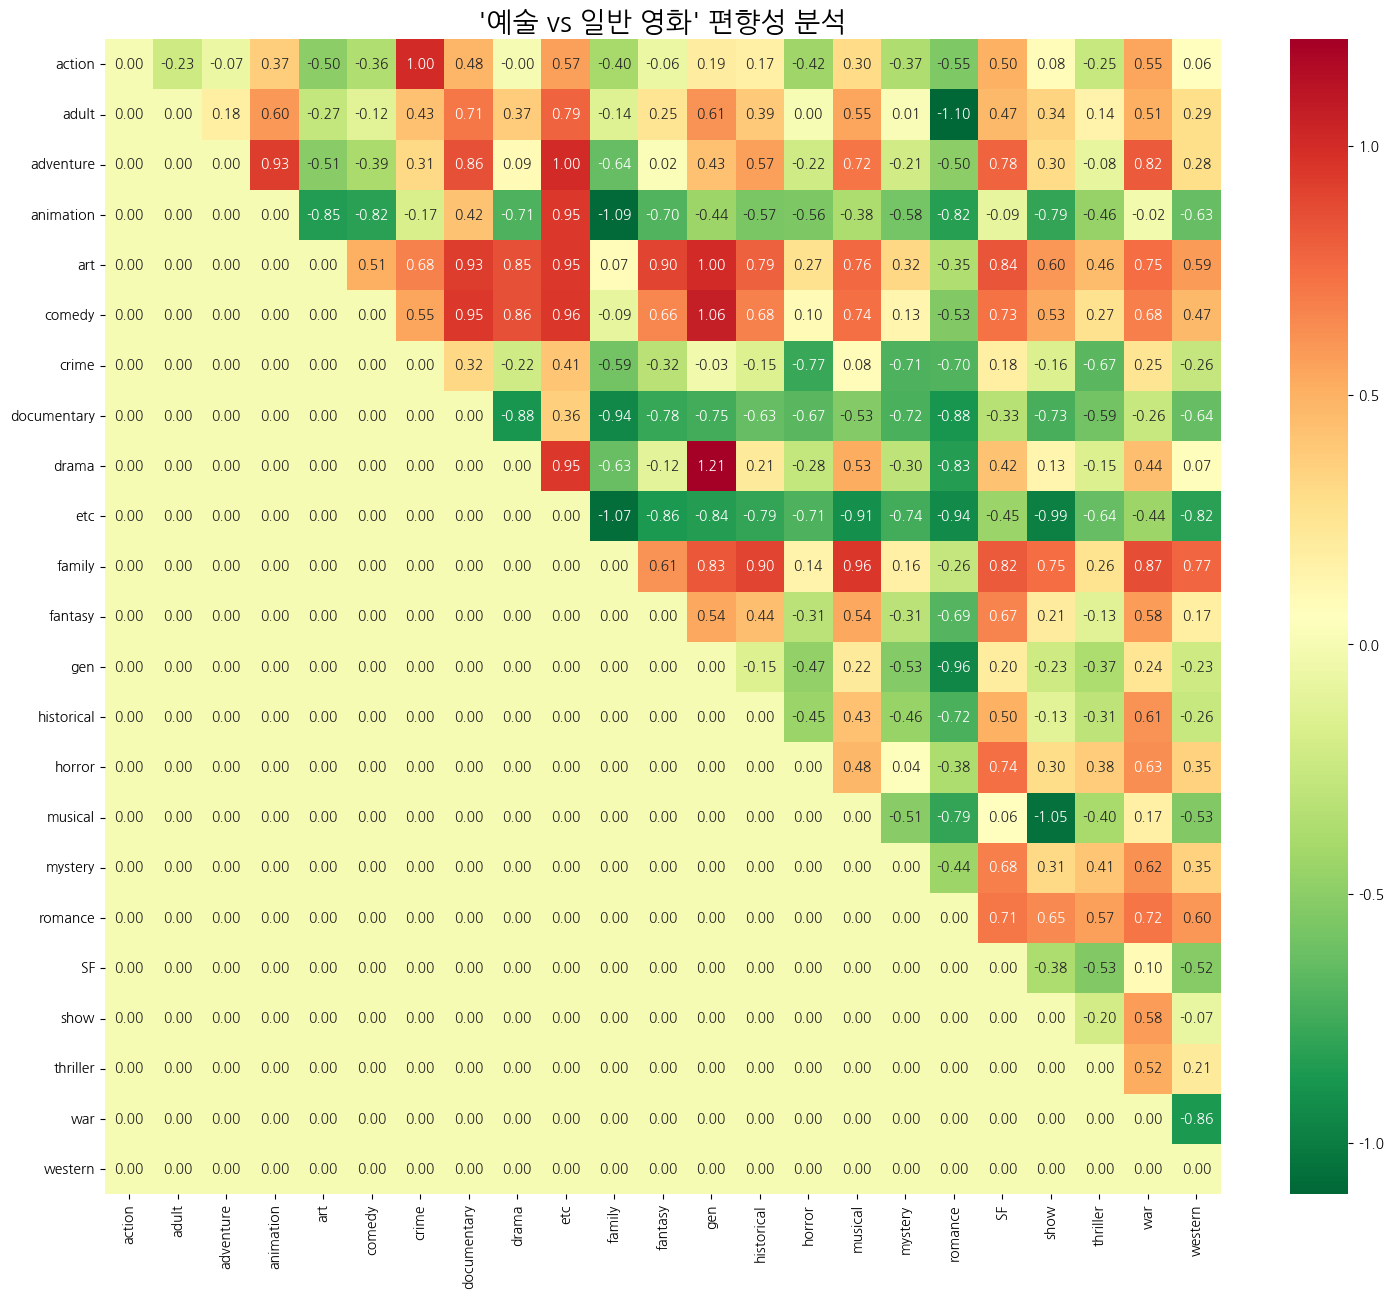

In [44]:
# --- 4. 히트맵 시각화 ---
plt.rc('font', family='NanumGothic') 
plt.rcParams['axes.unicode_minus'] = False 
plt.figure(figsize=(18, 15))
sns.heatmap(matrix, xticklabels=genre_names, yticklabels=genre_names, annot=True, cmap='RdYlGn_r', fmt='.2f')
plt.title("'예술 vs 일반 영화' 편향성 분석", fontsize=20)
plt.show()

상관관계 행렬 스타일로 히트맵 생성 중...


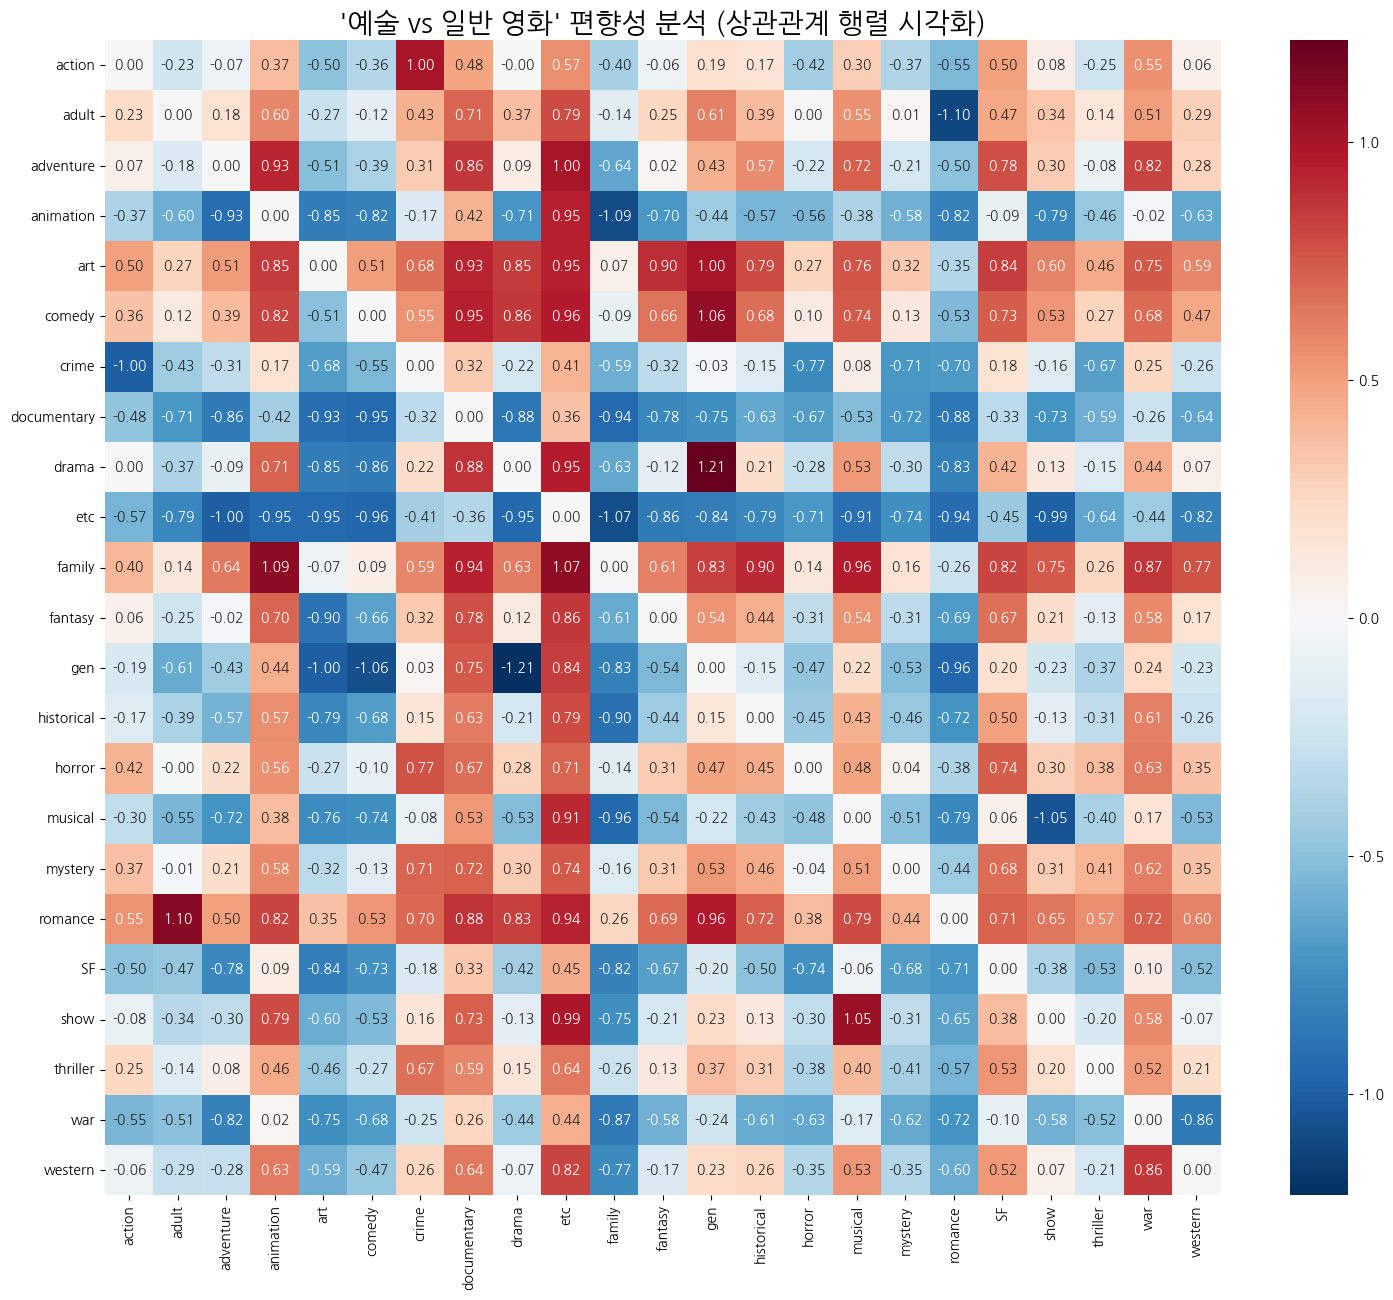

In [45]:


# --- [추가] 상관관계 행렬 스타일로 변환 ---
# WEAT(A,B) = -WEAT(B,A) 속성을 이용해 하단 삼각형 채우기
matrix_symmetric = matrix - matrix.T

# --- 4. 히트맵 시각화 ---
print("상관관계 행렬 스타일로 히트맵 생성 중...")
plt.rc('font', family='NanumGothic') 
plt.rcParams['axes.unicode_minus'] = False 
plt.figure(figsize=(18, 15))

# [수정] 대칭 행렬과 상관관계 시각화에 적합한 옵션 사용
sns.heatmap(matrix_symmetric, 
            xticklabels=genre_names, 
            yticklabels=genre_names, 
            annot=True, 
            cmap='RdBu_r',  # 빨강-파랑 계열의 컬러맵으로 변경
            fmt='.2f',
            center=0)      # 색상의 중앙값을 0으로 설정

plt.title("'예술 vs 일반 영화' 편향성 분석 (상관관계 행렬 시각화)", fontsize=20)
plt.show()

* 두 개의 명확한 장르 그룹 형성
  
-'예술영화'와 강하게 연관된 그룹:  
romance, art, family, comedy, drama   
추론: 인물 간의 관계나 내면의 감정 변화 중심 서사가 구조를 띔  
  
-'일반(상업)영화'와 강하게 연관된 그룹:  
crime, action, thriller, SF, war, documentary, animation   
추론: 특정 사건, 임무, 플롯 중심.  
   
   
* 뚜렸한 편향성을 보이는 장르  
-예술영화:   
adult romance 스코어가 -1.10으로, '로맨스'는 '예술영화'의 특성을 강하게 보임.  
  
  
* '뮤지컬'과 '공연(show)'에 대한 이해  
musical show 스코어: -1.049  
추론: 'show'가 '예술영화'와, '뮤지컬'이 '일반(상업)영화'와 연결됨.  
단어 셋을 보면 show는 오페라, 리골레토 등 클래식 '공연 실황'과 관련을 추정할 수 있고,  
musical은 상대적으로 더 대중적인 영화 뮤지컬을 포함하는 것으로 보임.  
  
  
* 기타: 특이점  
-animation family 스코어가 -1.086으로, '가족' 장르가 예술영화와 가깝고 '애니메이션'이 일반영화와 가깝다는 강한 편향을 보임. 애니메이션이 가족 보다 더 대중적이고 상업적인 장르로 인식되는가?  
-action crime 스코어는 1.00 데이터셋을 주관적인 관점으로 살펴볼 때 매우 유사해 보이는데 점수가 0이 아니라 크라임이 액션보다 일반(상업) 편향이 있는 것으로 나옴. 설마... 레이드 같은 제3세계 액션 영화가 예술영화로 인식되는 것일까?   
  
  
▶장르적 구분이 비교적 뚜렸이 나타난다고 보임.   
21개 장르가 상호 어떤 유사성을 가졌는지 시각화 해서 보기로함.  
  

💾 모델 및 최종 단어 셋 불러오는 중...
✅ 불러오기 완료!
장르별 대표 벡터(Centroid) 계산 중...
✅ 대표 벡터 계산 완료!
장르 간 유사도 행렬 계산 중...
✅ 유사도 계산 완료!

--- 🔥 유사도 0.9 이상인 장르 쌍 목록 ---
mystery & thriller: 0.9626
documentary & etc: 0.9320
etc & gen: 0.9290
drama & gen: 0.9247
animation & etc: 0.9212
horror & thriller: 0.9182
horror & mystery: 0.9120
adult & romance: 0.9110
action & crime: 0.9025
------------------------------------------

유사도 행렬 히트맵 생성 중...


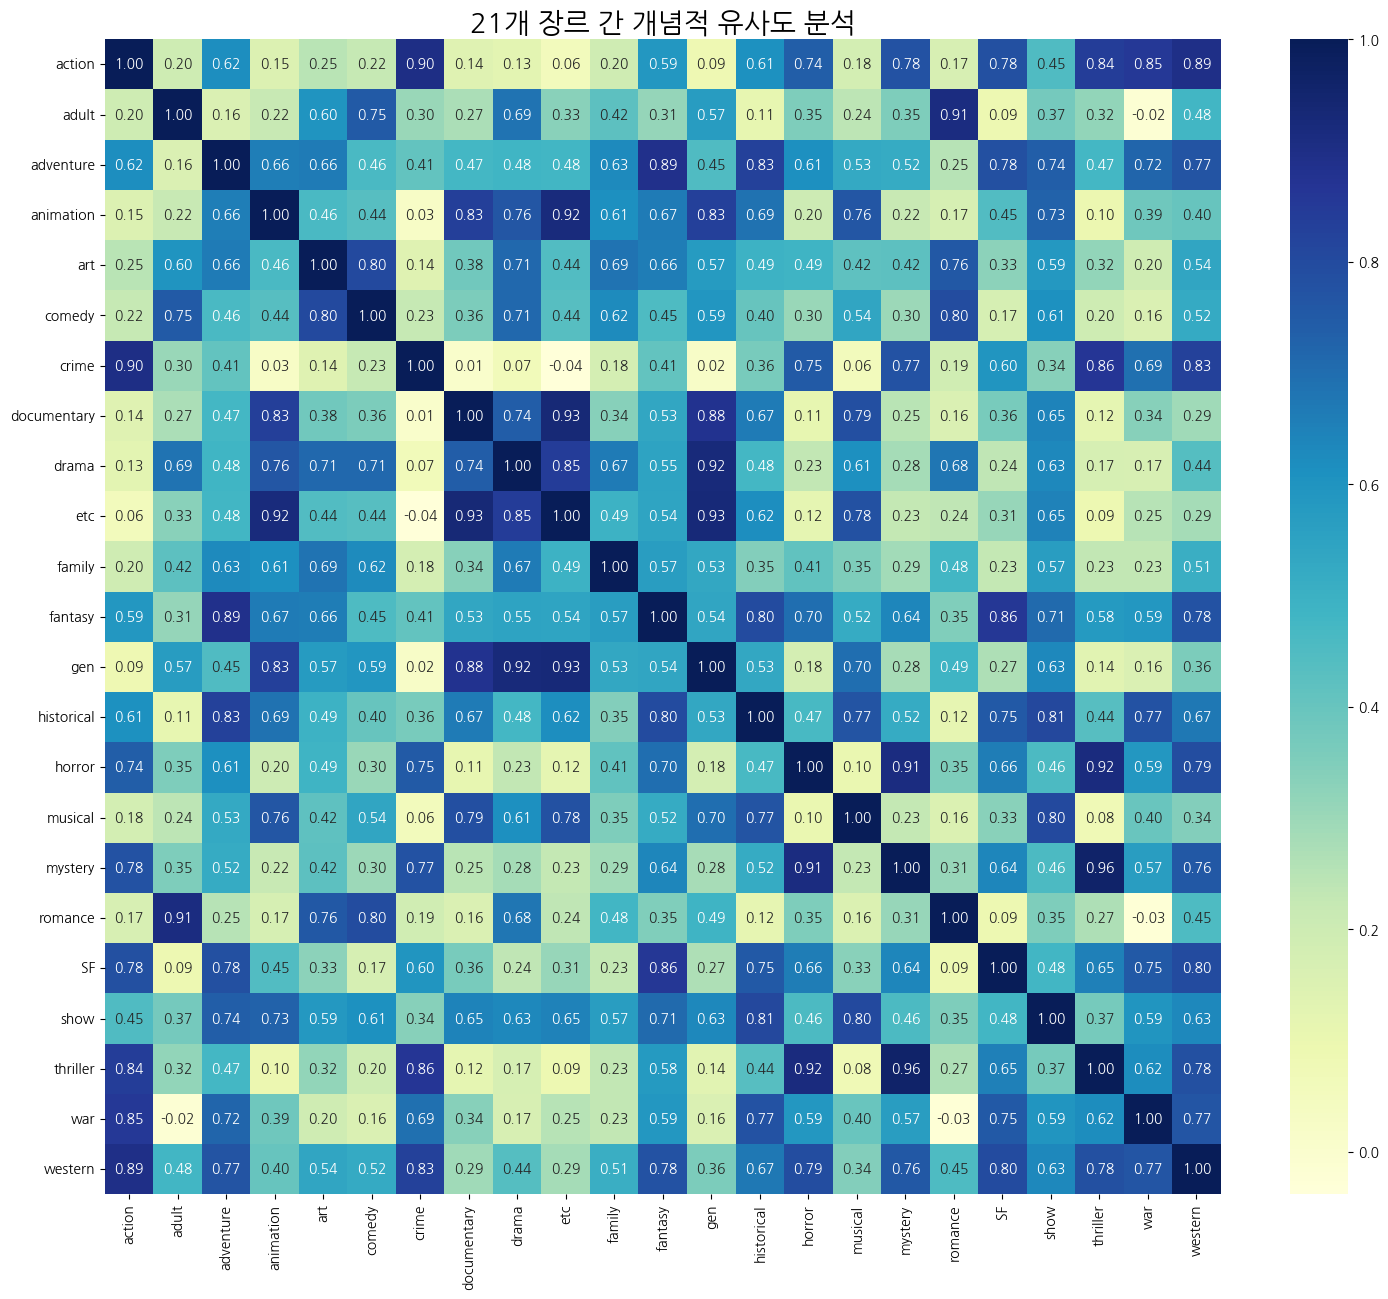

In [73]:
# === 필요한 라이브러리 임포트 ===
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from numpy import dot
from numpy.linalg import norm

# --- 1. 저장된 모델 및 '최종' 단어 셋 불러오기 ---
print("💾 모델 및 최종 단어 셋 불러오는 중...")
model = Word2Vec.load("word2vec.model")
with open('final_attribute_sets.pkl', 'rb') as f:
    final_sets = pickle.load(f)

attribute_sets = final_sets['attribute_sets']
genre_names = final_sets['genre_names']
print("✅ 불러오기 완료!")


# --- 2. 장르별 대표 벡터(Centroid) 계산 ---
print("장르별 대표 벡터(Centroid) 계산 중...")
genre_centroids = {}
for genre, words in attribute_sets.items():
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if word_vectors:
        genre_centroids[genre] = np.mean(word_vectors, axis=0)
print("✅ 대표 벡터 계산 완료!")


# --- 3. 장르 간 코사인 유사도 행렬 계산 ---
print("장르 간 유사도 행렬 계산 중...")
similarity_matrix = np.zeros((len(genre_names), len(genre_names)))

def cosine_similarity(v1, v2):
    return dot(v1, v2) / (norm(v1) * norm(v2))

for i, genre_A in enumerate(genre_names):
    for j, genre_B in enumerate(genre_names):
        if genre_A in genre_centroids and genre_B in genre_centroids:
            vec_A = genre_centroids[genre_A]
            vec_B = genre_centroids[genre_B]
            similarity_matrix[i, j] = cosine_similarity(vec_A, vec_B)
print("✅ 유사도 계산 완료!")


# --- [신규] 4. 유사도 0.9 이상인 장르 쌍 추출 및 출력 ---
high_similarity_pairs = []
# 중복을 피하기 위해 행렬의 상단 삼각형만 순회 (j > i)
for i in range(len(genre_names)):
    for j in range(i + 1, len(genre_names)):
        if similarity_matrix[i, j] > 0.90:
            # (장르 A, 장르 B, 유사도 점수) 튜플을 리스트에 추가
            high_similarity_pairs.append((genre_names[i], genre_names[j], similarity_matrix[i, j]))

# 유사도 점수가 높은 순으로 정렬
high_similarity_pairs.sort(key=lambda x: x[2], reverse=True)

print("\n--- 🔥 유사도 0.9 이상인 장르 쌍 목록 ---")
if high_similarity_pairs:
    for pair in high_similarity_pairs:
        print(f"{pair[0]} & {pair[1]}: {pair[2]:.4f}")
else:
    print("유사도 0.9 이상인 장르 쌍이 없습니다.")
print("------------------------------------------")


# --- 5. 유사도 행렬 히트맵 시각화 ---
print("\n유사도 행렬 히트맵 생성 중...")
plt.rc('font', family='NanumGothic') 
plt.rcParams['axes.unicode_minus'] = False 

plt.figure(figsize=(18, 15))
sns.heatmap(similarity_matrix, 
            xticklabels=genre_names, 
            yticklabels=genre_names, 
            annot=True, 
            cmap='YlGnBu',
            fmt='.2f')

plt.title("21개 장르 간 개념적 유사도 분석", fontsize=20)
plt.show()

* 유사도 분석  
mystery & thriller: 0.9626  
horror & thriller: 0.9182  
horror & mystery: 0.9120  
adult & romance: 0.9110  
action & crime: 0.9025
  
유사도로 봐도 대부분이 납득이 가는 결과다.  
그런데  
전쟁과 로멘스는 점수가 -0.03이다.  
아니 전쟁에서 핀 사랑이 얼마나 많은데 ...ㅜㅜ  
    

-끝-